## Single forcing contribution to polar amplification : feedback analysis
This notebook will load the following single forcing ensemble data:<br>
<ul>
    <li>historical (50 member)
    <li>historicalNat (50 member): volcano and solar irradiance
    <li>historicalMisc/AA p4 (50 member): anthropogenic aerosols
    <li>historicalMisc/SO p6 (50 member): stratospheric ozone
    <li>historicalGHG (5 member): greenhouse gases
    <li>historicalMisc/LU p2 (5 member): land-use change
    <li>historicalMisc/SI p3 (5 member): solar irradiance @@Maybe not b/c it's included in Nat?</ul>
<br>
Calculate time averages (1981-2005) and anomalies from preindustrial (piControl) for each month for the following variables (starting w/ bare-bones feedbacks (no clouds)):<br>
<ul>
    <li>tas
    <li>ts
    <li>sfc absorbed solar (?)
    <li>sfc albedo
    <li>T
    <li>Q</ul>

And perform the steps to calculate feedbacks based on calc_dX_LME.m and computeLMEfb.m (see notes below).

## For reference: here is what is in each ensemble:
historical + rcp8.5: 1950 -> 2100<br>
<li>  Forcings: <b>GHG, Oz, SA, BC, OC, LU, SI, VI (GHG includes CO2, CH4, N2O, CFC11, effective CFC12)</b>

historicalNat (solar / volcano): 1950 -> 2020<br>
<li>  Forcings: <b>Sl (this is SL with lower case l), Vl (VL with lower case l)</b>

historicalMisc p4 (anthropogenic aerosol only): 1950 -> 2020<br>
<li>  Forcings: <b>AA (what’s in here? Prob: SA, BC, OC. Oz??)</b>

historicalMisc p6 (strato ozone only): 1950 -> 2100<br>
<li>  Forcings: <b>SO</b>
 


<b>PSEUDOCODE of CC's matlab: calc_dX_LME</b>

<li>get grid info from one of the files: lat, lon, lev, nlat,nlon,nlev
<li>load 2d variables: 'TS';'TREFHT';'FSNS';'FSDS';'FSNSC';'FSDSC';'FLNT';'FLNTC';'FSNT';'FSNTC'<br>
Here would be: gt, tas.... <br>
<li>Each month read in separately (from separate files I think)
<br>
<li>load 3d variables: T, Q
<br>
<li>compute differences:
  dQ = log(Q_pert)-log(Q-ctl)
  dTs = TS_pert - TS_ctl
  etc... for TAS and T

<li>read in PS and OCEANFRAC 

<li>create a mask of "always ocean" grid cells (no changes b/c our control and pert sims?)

<li>interpolate to kernel grid (CAM3) for e/ level and month 
   (I am not following this section of code)

<li>Compute albedo and clearsky albedo, and LW and SW CRF
   Includes hack to set ocean albedo to 0.06 where it's always ocean
   (b/c it actually depends on zenith angle..)

<li>compute differences for albedo, clearsky albedo, LW/SW CRF


Questions for CC:
  1. Is oceanfrac a constant? I assume so but maybe not for LME?
  2. Multiple interp loops, why?
  3. Why do we need surface temp and 2m temp?




#### PSEUDOCODE of CC's matlab: computefeedbacks

load kernels<br>
load anomalies from calc_dX_LME : ts, sat, Q, <br>
compute 3D air temp - surface temp (ts) at every level<br>
feedbacks to be vertically integrated:
<ul><li>lapse rate: ta kernel mult by air temp - surface temp (ts)
    <li>water vapor: spec hum kernel mult by dQ (lw and sw kernels are separated)
    <li>... </ul>
vertically integrate up to ptop (what is ptop? 100+200/90\*abs(latker) ?)<br>
<ul><li>3D air temp
    <li>temp kernel
    <li>lapse rate
    <li>water vapor (lw and sw) </ul>
<br>
compute zonal mean, annual mean SAT (for use in normalizing feedbacks): dTsANN<br>
compute global mean, annual mean TS (also for use in normalizing): dTsglob<br>
compute feedbacks:
<ul><li>planck surface: 10 x ts kernel x ts anom / dTsAnn
    <li>planck air: vert integral of ta kernel x ts anom / dTsANN
    <li>total planck: planck surface + air
    <li>albedo: 10 x alpha kernel x alpha anom / dTsANN (fill NaN with zero)
    <li>lapse rate: vert integral of lapse rate / dTsANN
    <li>water vapor: vert integral of wv / dTsANN </ul>
<br>
cloud corrections -- don't have cloud (clearsky/allsky) info (yet?)<br>
<br>
when use dTsglob?


### set up metadata to run script

In [1]:
import xarray as xr
import cccmautils as cutl
import dataset_utils as dsu

%matplotlib inline 

threed=False # load and process 3-D variables?
doplots=False


TIMESEL=('1981','2005') # Note: SO file is split at year 2000 - need to process/fix@@
TIMESEL=('2001','2010') # Marvel
compDT = {'tas': 'Amon',
          'albedo':'Amon',
          'abssol':'Amon',
          'ts':'Amon', 
          'ta':'Amon',
          'hus':'Amon',
          'nettoa': 'Amon'}
pnumDT = {'all':'1', 'nat':'1','aa':'4','so':'6',
          'ghg':'1','lu':'2','si':'3'}
ensnamesDT = {'all':'historical', 'nat':'historicalNat',
              'aa':'historicalMisc','so':'historicalMisc',
              'ghg':'historicalGHG','lu':'historicalMisc',
              'si':'historicalSI'}
timeextDT={'all':'195001-202012',
           'nat': '195001-202012',
           'aa': '195001-202012',
           'so': '195001-200012',
           'ghg':'185001-201212',
           'lu':'185001-201212',
           'si':'185001-201212'}

dirsDT = {'all':('/Users/kelly/DATA/CanSISE/CanESM2/LE/','-r?'),
          'nat':('/Users/kelly/DATA/CanSISE/CanESM2/LE/','-r?'),
          'aa':('/Users/kelly/DATA/CanSISE/CanESM2/LE/','-r?'),
          'so':('/Users/kelly/DATA/CanSISE/CanESM2/LE/','-r?'),
          'ghg':('/Users/kelly/DATA/CanSISE/CanESM2/',''),
          'lu':('/Users/kelly/DATA/CanSISE/CanESM2/',''),
          'si':('/Users/kelly/DATA/CanSISE/CanESM2/','')}

remdirsDT = {'all':('/Volumes/KellyDataDisk/home/work/DATA/CanESM2/LE/','-r?'),
          'nat':('/Volumes/KellyDataDisk/home/work/DATA/CanESM2/LE/','-r?'),
          'aa':('/Volumes/KellyDataDisk/home/work/DATA/CanESM2/LE/','-r?'),
          'so':('/Volumes/KellyDataDisk/home/work/DATA/CanESM2/LE/','-r?'),
          'ghg':('/Volumes/KellyDataDisk/home/work/DATA/CanESM2/',''),
          'lu':('/Volumes/KellyDataDisk/home/work/DATA/CanESM2/',''),
          'si':('/Volumes/KellyDataDisk/home/work/DATA/CanESM2/','')}

colordt = {'all':'purple',
           'nat':'0.5',
           'aa':'blue',
           'ghg':'red',
           'so':'cyan',
           'lu':'green',
           'si':'orange'}


### Load 2D single forcing ensemble data

In [2]:
caseDS={}

# 2D vars
for ensname in ('all','nat','aa','so','ghg','lu'):# si:
    casename=ensnamesDT[ensname]
    pnum=pnumDT[ensname]
    timeext = timeextDT[ensname]
    basepath,subd = dirsDT[ensname]
    fldDS={}

    for field in ('tas','ts','abssol','albedo','nettoa'):
            
        comp = compDT[field]
        fn = basepath+'/'+casename+subd+'/'+field+'/'+field+'_'+comp+'_CanESM2_'+casename+\
             subd+'_r*i1p'+pnum+'_'+timeext+'.nc'
        print fn
        # this creates a new dimension to concatenate on
        if ensname=='so': # @@@ hack
            fldDS[field] = xr.open_mfdataset(fn,concat_dim='ensemble',
                                             autoclose=True).sel(time=slice('1991','2000'))
        else:
            fldDS[field] = xr.open_mfdataset(fn,concat_dim='ensemble',
                                             autoclose=True).sel(time=slice(TIMESEL[0],TIMESEL[1]))
        #print fldDS[field]

    caseDS[ensname] = fldDS

# get lat,lon once
lat = caseDS['all']['tas']['lat']
lon = caseDS['all']['tas']['lon']



/Users/kelly/DATA/CanSISE/CanESM2/LE//historical-r?/tas/tas_Amon_CanESM2_historical-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historical-r?/ts/ts_Amon_CanESM2_historical-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historical-r?/abssol/abssol_Amon_CanESM2_historical-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historical-r?/albedo/albedo_Amon_CanESM2_historical-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historical-r?/nettoa/nettoa_Amon_CanESM2_historical-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historicalNat-r?/tas/tas_Amon_CanESM2_historicalNat-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historicalNat-r?/ts/ts_Amon_CanESM2_historicalNat-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historicalNat-r?/abssol/abssol_Amon_CanESM2_historicalNat-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historicalNat-r?/albedo/albedo_Amon_

### load control data: note 100 years for now

In [3]:
""" Note that due to a limitation in pandas(?) datetime, the piControl
    time axis isn't read in properly, so I can't use groupby, etc.
    I will try to use cdo to set the time axis to 1000 years earlier and see if that works.
    
    From user guide:
    To set the time axis to 1987-01-16 12:00:00 with an increment of one month for each timestep use:
   
    cdo settaxis,1987-01-16,12:00:00,1mon infile outfile
    This didn't work (introduced new error). Instead, use shifttime. 
    # Related to this issue: https://github.com/pandas-dev/pandas/issues/7307
    # .  and this: https://github.com/spencerahill/aospy/issues/98
    # So I shifted the time axis with cdo
    # cdo shifttime,-1000years tas_Amon_CanESM2_piControl_r1i1p1_291101-301012.nc 
    # .    tas_Amon_CanESM2_piControl_r1i1p1_191101-201012.nc
    
    # If doing the whole ~1000 years, need to shift by 1100 years. 
    # @@Actually still doesn't allow groupby time.month etc. Choosing the last 500 years doesn't work either.
    # 
   
"""
# @@ leave it at 100 years for now b/c reading in longer time periods, even w/ shifttime doesn't work.
ctltimeper='191101-201012' #'151101-191012'#'091501-191012'#'101501-201012' # 191101-201012

ctlmapDS={}; ctlgmDS={}
for field in ('tas','albedo','ts','abssol','nettoa'):
    fn='/Users/kelly/DATA/DataDisk/piControl/'+field+'/'+field+\
       '_'+compDT[field]+'_CanESM2_piControl_r1i1p1_'+ctltimeper+'.nc'#291101-301012.nc'
    
    print fn
    #ctlDS[field] = xr.open_dataset(fn)
    #print ctlDS[field][field].data.shape

    ctlmapDS[field] = dsu.calc_monthly_mean_ds(xr.open_dataset(fn))# month x lev x lat x lon (climo) 
    ctlgmDS[field] = dsu.calc_areaweight_mean_ds(ctlmapDS[field],dim=('lat','lon')) # monthly global mean

    
if threed: # do not have these variables for piControl yet
    
    basepath = '/Volumes/KellyDataDisk/home/work/DATA/CanESM2/'+casename+'/'
    
    for field in ('ta','hus'):
        fn=basepath+field+'/'+field+\
           '_'+compDT[field]+'_CanESM2_piControl_r1i1p1_'+ctltimeper+'.nc'

        print fn
        #ctlDS[field] = xr.open_dataset(fn)
        #print ctlDS[field][field].data.shape

        ctlmapDS[field] = dsu.calc_monthly_mean_ds(xr.open_dataset(fn))# month x lev x lat x lon (climo) 
        ctlgmDS[field] = dsu.calc_areaweight_mean_ds(ctlmapDS[field],dim=('lat','lon')) # monthly global mean per level
        ##print ctlgmds[field] # climo global mean, time mean

else:
    print 'will load intermediate 3D data from file @@'


/Users/kelly/DATA/DataDisk/piControl/tas/tas_Amon_CanESM2_piControl_r1i1p1_191101-201012.nc
/Users/kelly/DATA/DataDisk/piControl/albedo/albedo_Amon_CanESM2_piControl_r1i1p1_191101-201012.nc
/Users/kelly/DATA/DataDisk/piControl/ts/ts_Amon_CanESM2_piControl_r1i1p1_191101-201012.nc
/Users/kelly/DATA/DataDisk/piControl/abssol/abssol_Amon_CanESM2_piControl_r1i1p1_191101-201012.nc
/Users/kelly/DATA/DataDisk/piControl/nettoa/nettoa_Amon_CanESM2_piControl_r1i1p1_191101-201012.nc
will load intermediate 3D data from file @@


### Load 3D data from external

In [4]:
climoDS={}; 
if threed:
    # Access 3D vars on external? Yes they are huge
    for ensname in ('all','nat','aa','so','ghg','lu'):#,'si')

        casename=ensnamesDT[ensname]
        pnum=pnumDT[ensname]
        timeext = timeextDT[ensname]
        basepath,subd = remdirsDT[ensname]
        fldDS={}

        for field in ('ta','hus'):

            if ensname in ('nat','aa',) and field=='hus':
                continue
                
            comp = compDT[field]
            fn = basepath+'/'+casename+subd+'/'+field+'/'+field+'_'+comp+'_CanESM2_'+casename+\
                 subd+'_r*i1p'+pnum+'_'+timeext+'.nc'
            print fn
            # this creates a new dimension to concatenate on
            fldtmp = xr.open_mfdataset(fn,concat_dim='ensemble',autoclose=True).\
                            sel(time=slice(TIMESEL[0],TIMESEL[1]))
            fldDS[field] = dsu.calc_monthly_mean_ds(fldtmp.mean(dim='ensemble')) # month x lev x lat x lon climo
            
        climoDS[ensname] = fldDS

    # get lev once
    lev = caseDS['all']['ta']['plev']

else:
    print 'will load intermediate 3D data from files'


will load intermediate 3D data from files


In [10]:
# calc_dX_LME

# Compute monthly average maps.
# Compute anomaly from preindustrial control (TODO: include more years)
# TODO: add variables: T, Q
climoDS={}; climanomDT={}; gmensDS={}
for ens in ('all','nat','aa','so','ghg','lu'): #, 'si'):
    fldDS={}; anomDT={}; fldgmensDS={}
    for field in ('tas','ts','abssol','albedo','nettoa'):
        
        tmpfld = caseDS[ens][field].mean(dim='ensemble')
        fldDS[field] = dsu.calc_monthly_mean_ds(tmpfld)
        anomDT[field] = fldDS[field][field].data - ctlmapDS[field][field].data # failed when kept as Dataset
        
        # keep ensemble dim, ann-glob mean
        tmpens = dsu.calc_annual_mean_ds(caseDS[ens][field]).mean(dim='year')
        tmpgm = dsu.calc_areaweight_mean_ds(tmpens,dim=('lat','lon'))
        fldgmensDS[field] = tmpgm # global mean, annual mean, but w/ ensemble dim
        
    climoDS[ens] = fldDS # just lat x lon
    climanomDT[ens] = anomDT
    gmensDS[ens] = fldgmensDS
    
# Result in clim*[] is a map for each month (and level if 3D)

#print climoDS




### plot loaded data

(12, 64, 128)
<class 'dask.array.core.Array'>
(12, 64, 128)


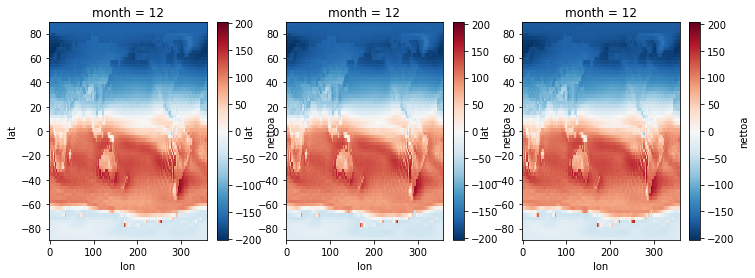

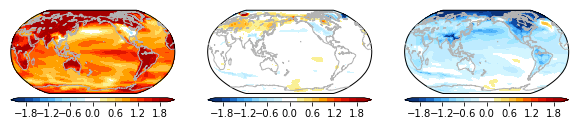

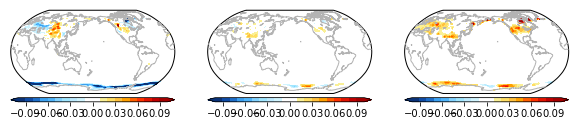

In [198]:
doplots=True

if doplots:
    
    fig,axs=plt.subplots(1,3,figsize=(12,4))
    ax=axs[0]
    climoDS['aa']['nettoa'].sel(month=12)['nettoa'].plot(ax=ax)
    ax=axs[1]
    climoDS['so']['nettoa'].sel(month=12)['nettoa'].plot(ax=ax)
    ax=axs[2]
    climoDS['all']['nettoa'].sel(month=12)['nettoa'].plot(ax=ax)

    print climoDS['all']['tas']['tas'].shape

    print type(climanomDT['all']['tas'])
    print climanomDT['all']['tas'].shape

    field='tas'; arraymon=11
    fig,axs=plt.subplots(1,3,figsize=(10,4))
    ax=axs[0]
    cplt.kemmap(climanomDT['all'][field][arraymon],lat,lon,cmin=-2,cmax=2,axis=ax)
    ax=axs[1]
    cplt.kemmap(climanomDT['nat'][field][arraymon],lat,lon,cmin=-2,cmax=2,axis=ax)
    ax=axs[2]
    cplt.kemmap(climanomDT['aa'][field][arraymon],lat,lon,cmin=-2,cmax=2,axis=ax)

    cmin=-.1; cmax=.1
    field='albedo'
    fig,axs=plt.subplots(1,3,figsize=(10,4))
    ax=axs[0]
    cplt.kemmap(climanomDT['all'][field][arraymon],lat,lon,cmin=cmin,cmax=cmax,axis=ax)
    ax=axs[1]
    cplt.kemmap(climanomDT['nat'][field][arraymon],lat,lon,cmin=cmin,cmax=cmax,axis=ax)
    ax=axs[2]
    cplt.kemmap(climanomDT['aa'][field][arraymon],lat,lon,cmin=cmin,cmax=cmax,axis=ax)



### Compute dTAS, dNETTOA and get RF for Marvel Fig.

In [6]:
# data from Jason Cole (my document w/ table)
RFdt = {'all':1.59,
        'ghg': 2.44,
        'CO2': 1.35,
        'CH4': 0.50,
        'N2O': 0.10,
        'CFC': 0.41,
        'O3trop': 0.23,
        'O3strat':-0.30,
        'O3': -0.08,
        'aa': -0.79,
        'lu': -0.02,
        'nat': 0,
        'so': -0.30,
        'si': np.nan
        } 
# GHG = sum of CO2, CH4, N2O, CFCs ((1.35+0.50+0.10+0.41)=2.36)
# CO2, CH4, N2O, CFCs at 2005 from RCP4.5
# 'aa' is all aero at 2005 from RCP4.5 --> not anthro only? @@
# .   note 'aa' for 2005 from RCP8.5 is -0.71
# 'nat' is hard-coded to 0 for now.



### Compare sum of individual to 'all'

In [10]:
print 1.35+0.50+0.10+0.41
indsum = RFdt['ghg']+RFdt['aa']+RFdt['lu']+RFdt['nat']
indsumoz = indsum+RFdt['so']+RFdt['O3trop']
ghgsum = RFdt['CO2']+RFdt['CH4']+RFdt['N2O']+RFdt['CFC']
print indsum,ghgsum
print ''
print 'compare sum (ghg,aa,lu,nat) ' + str(indsum) + ' to all ' + str(RFdt['all'])
print 'compare sum (ghg,aa,lu,nat,so,O3trop) ' + str(indsumoz) + ' to all ' + str(RFdt['all'])

print 'compare ghg sum '  + str(ghgsum) + ' to ghg ' + str(RFdt['ghg'])



2.36
1.63 2.36

compare sum (ghg,aa,lu,nat) 1.63 to all 1.59
compare sum (ghg,aa,lu,nat,so,O3trop) 1.56 to all 1.59
compare ghg sum 2.36 to ghg 2.44


### calculate annual, global mean anomalies

In [11]:
dsu = reload(dsu)

# take climanomDT and calc global, annual mean

gmDT={}; gmanomDT={}
for ens in ('all','nat','aa','so','ghg','lu'): #, 'si'):
    ctlannds={}; ctlgmds={}; annds={}; gmds={}; anomds={}
    
    for field in ('tas','nettoa'):
        
        ctlannds[field] = dsu.calc_annual_mean_ds(ctlmapDS[field])
        ctlgmds[field] = dsu.calc_areaweight_mean_ds(ctlannds[field],dim=('lat','lon'))

        datds = climoDS[ens][field] #climanomDT[ens][field]    
        annds[field] = dsu.calc_annual_mean_ds(datds)
        gmds[field] = dsu.calc_areaweight_mean_ds(annds[field], dim=('lat','lon'))
        anomds[field] = (gmds[field] - ctlgmds[field])[field].values
    
    gmDT[ens] = gmds
    gmanomDT[ens] = anomds
    

### Document ECS, TCR calcs / ensemble

$$ TCR = \frac{F_{2CO2}}{lamda_{TCR}} = \frac{F_{2CO2}}{(\frac{dF}{dT})} $$
<br>
$$ ECS = \frac{F_{2CO2}}{lamda_{ECS}} = \frac{F_{2CO2}}{(\frac{(dF-dQ)}{dT})} $$

all: 
<ul><li>dF = 1.59; dQ = 0.84; (dF-dQ) = 0.75; dT = 1.16<br>
<li>lam$_{TCR}$ = 1.37
<li>lam$_{ECS}$ = 0.65
<li>TCR = 2.58
<li>ECS = 5.46</ul>

ghg: 
<ul><li>dF = 2.44; dQ = 0.85; (dF-dQ) = 1.59; dT = 1.69<br>
<li>lam$_{TCR}$ = 1.45
<li>lam$_{ECS}$ = 0.94
<li>TCR = 2.45
<li>ECS = 3.76</ul>

aerosol:
<ul><li>dF = -0.79; dQ = -0.21; (dF-dQ) = -0.58; dT = -0.58<br>
<li>lam$_{TCR}$ = 1.37
<li>lam$_{ECS}$ = 1.01
<li>TCR = 2.58
<li>ECS = 3.49</ul>

<br>
Options for $F_{2CO2}$ are: <br>
7.35 / 2 = 3.675 (CanESM2 values from Andrews et al. 2012)<br>
7.42 / 2 = 3.71 (value from CanESM2 4xCO2 fixed SST sim)<br>
3.54 (value from CanESM2 2xCO2 fixed SST sim) ** *used in calcs below**<br>
<br>


### calculate ECS and TCR

In [15]:
T2xco2 = 3.8 # Armour 2017 for CanESM2

rfkeys = gmanomDT.keys()
Fco2 = 3.54 #7.35 / 2. # from Andrews et al. 2012 showing CanESM2 4xCO2 RF
field='tas'
CS={}; lamTCR={}; lamECS={}; TCR={}; ECS={}
legstrstcr=[]; legstrsecs=[]
for rfk in gmanomDT.keys():
    print rfk
    print '  dF,dQ,dT,(dF-dQ): '+str(RFdt[rfk]),str(gmanomDT[rfk]['nettoa']),\
    str(gmanomDT[rfk][field]),str(RFdt[rfk]-gmanomDT[rfk]['nettoa'])
    lamTCR[rfk] = RFdt[rfk] / gmanomDT[rfk][field]  
    lamECS[rfk] = (RFdt[rfk]-gmanomDT[rfk]['nettoa']) / gmanomDT[rfk][field]
    print '  lamTCR, lamECS: ' + str(lamTCR[rfk]), str(lamECS[rfk])
    TCR[rfk] = Fco2/lamTCR[rfk]
    ECS[rfk] = Fco2/lamECS[rfk]
    legstrstcr.append(rfk + ': %1.2f $^\circ$C'%(Fco2/lamTCR[rfk]))
    legstrsecs.append(rfk + ': %1.2f $^\circ$C'%(Fco2/lamECS[rfk]))
    print '  TCR, ECS: ' + str(TCR[rfk]),str(ECS[rfk])
CS['TCR'] = TCR
CS['ECS'] = ECS



aa
  dF,dQ,dT,(dF-dQ): -0.79 -0.206075177123 -0.575905881597 -0.583924822877
  lamTCR, lamECS: 1.37175192205 1.01392404825
  TCR, ECS: 2.58064154538 3.49138577601
all
  dF,dQ,dT,(dF-dQ): 1.59 0.838484372172 1.15913917696 0.751515627828
  lamTCR, lamECS: 1.37170758405 0.648339425298
  TCR, ECS: 2.58072496001 5.46010293662
ghg
  dF,dQ,dT,(dF-dQ): 2.44 0.852463403095 1.68786000984 1.58753659691
  lamTCR, lamECS: 1.44561751909 0.940561769134
  TCR, ECS: 2.44878050608 3.76370815418
lu
  dF,dQ,dT,(dF-dQ): -0.02 -0.0127919896082 0.0565400389526 -0.00720801039179
  lamTCR, lamECS: -0.353731627542 -0.127485062361
  TCR, ECS: -10.0075868946 -27.7679591195
so
  dF,dQ,dT,(dF-dQ): -0.3 -0.104689120062 0.00521247303294 -0.195310879938
  lamTCR, lamECS: -57.5542545936 -37.4699070295
  TCR, ECS: -0.0615071817887 -0.0944758148776
nat
  dF,dQ,dT,(dF-dQ): 0 0.0943015242529 -0.0270715692994 -0.0943015242529
  lamTCR, lamECS: -0.0 3.48341550539
  TCR, ECS: -inf 1.01624396932


/Users/kelly/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in double_scalars
/Users/kelly/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in double_scalars


### Components of ECS, TCR calcs / ensemble

(-6, 6)

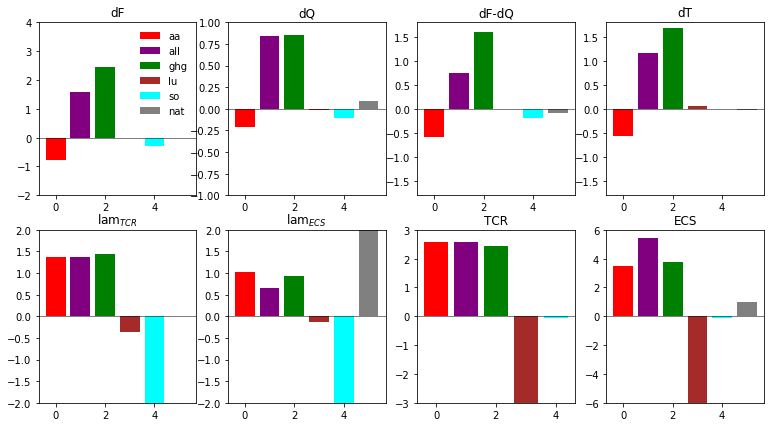

In [17]:
marcolordt = {'all':'purple',
               'nat':'0.5',
               'aa':'red',
               'ghg':'green',
               'so':'cyan',
               'lu':'brown',
               'si':'yellow',
               'vi': 'orange'}
colordt=marcolordt

# plot the components of the TCR/ECS calcs - why 'all' so high? think it's dQ

barx=np.arange(0,len(RFdt.values()))

fig,axs= plt.subplots(2,4,figsize=(13,7))
ax=axs[0,0]
for rii,rfk in enumerate(gmanomDT.keys()):  
    ax.bar(rii,RFdt[rfk],color=colordt[rfk])
ax.set_title('dF')
ax.legend(gmanomDT.keys(),loc='upper right',frameon=False)
ax.axhline(y=0,color='k',linewidth=.5)
ax.set_ylim((-2,4))

ax=axs[0,1]
for rii,rfk in enumerate(gmanomDT.keys()):  
    ax.bar(rii,gmanomDT[rfk]['nettoa'],color=colordt[rfk])
ax.axhline(y=0,color='k',linewidth=.5)
ax.set_title('dQ')
ax.set_ylim((-1,1))

ax=axs[0,2]
for rii,rfk in enumerate(gmanomDT.keys()):  
    ax.bar(rii,(RFdt[rfk]-gmanomDT[rfk]['nettoa']),color=colordt[rfk])
ax.axhline(y=0,color='k',linewidth=.5)
ax.set_title('dF-dQ')
ax.set_ylim((-1.8,1.8))

ax=axs[0,3]
for rii,rfk in enumerate(gmanomDT.keys()):  
    ax.bar(rii,gmanomDT[rfk]['tas'],color=colordt[rfk])
ax.axhline(y=0,color='k',linewidth=.5)
ax.set_title('dT')
ax.set_ylim((-1.8,1.8))

ax=axs[1,0]
for rii,rfk in enumerate(gmanomDT.keys()):  
    ax.bar(rii,lamTCR[rfk],color=colordt[rfk])
ax.set_title('lam$_{TCR}$')
ax.axhline(y=0,color='k',linewidth=.5)
ax.set_ylim((-2,2))

ax=axs[1,1]
for rii,rfk in enumerate(gmanomDT.keys()):  
    ax.bar(rii,lamECS[rfk],color=colordt[rfk])
ax.set_title('lam$_{ECS}$')
ax.axhline(y=0,color='k',linewidth=.5)
ax.set_ylim((-2,2))

ax=axs[1,2]
for rii,rfk in enumerate(gmanomDT.keys()):  
    ax.bar(rii,TCR[rfk],color=colordt[rfk])
ax.set_title('TCR')
ax.axhline(y=0,color='k',linewidth=.5)
ax.set_ylim((-3,3))

ax=axs[1,3]
for rii,rfk in enumerate(gmanomDT.keys()):  
    ax.bar(rii,ECS[rfk],color=colordt[rfk])
ax.set_title('ECS')
ax.axhline(y=0,color='k',linewidth=.5)
ax.set_ylim((-6,6))


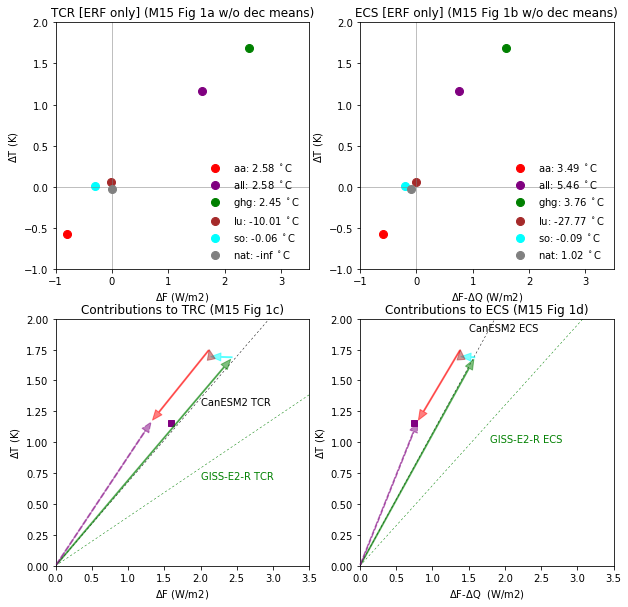

In [126]:


printtofile=False
ms=8

fig,axs = plt.subplots(2,2,figsize=(10,10))
ax=axs[0,0]
field='tas'
for rfk in gmanomDT.keys():
    ax.plot(RFdt[rfk], gmanomDT[rfk][field],marker='o',markersize=ms,
           color=colordt[rfk],linestyle='none')
ax.axhline(y=0,color='0.5',linewidth=0.5)
ax.axvline(x=0,color='0.5',linewidth=0.5)
ret = ax.legend(legstrstcr,frameon=False,loc='lower right')
ax.set_xlabel('$\Delta$F (W/m2)')
ax.set_xlim((-1,3.5))
ax.set_ylim((-1,2))
ax.set_ylabel('$\Delta$T (K)')
ax.set_title('TCR [ERF only] (M15 Fig 1a w/o dec means)')

ax=axs[0,1]
for rfk in gmanomDT.keys():
    ax.plot(RFdt[rfk]-gmanomDT[rfk]['nettoa'], gmanomDT[rfk][field],
            marker='o',markersize=ms,color=colordt[rfk],linestyle='none')

ax.axhline(y=0,color='0.5',linewidth=0.5)
ax.axvline(x=0,color='0.5',linewidth=0.5)
ret = ax.legend(legstrsecs,frameon=False,loc='lower right')
ax.set_xlabel('$\Delta$F-$\Delta$Q (W/m2)')
ax.set_xlim((-1,3.5))
ax.set_ylim((-1,2))
ax.set_ylabel('$\Delta$T (K)')
ax.set_title('ECS [ERF only] (M15 Fig 1b w/o dec means)')

headl=10
headw=8
ax=axs[1,0]
ax.plot(RFdt['all'], gmanomDT['all'][field],marker='s',markersize=6,
        color=colordt['all'])
# xy is head loc, xytext is tail loc  
ax.annotate('',xy=(RFdt['ghg'], gmanomDT['ghg'][field]), 
            xytext=(0,0),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['ghg'],
                            edgecolor=colordt['ghg'],shrink=.01,alpha=0.5)) 
xtail=RFdt['ghg']
ytail=gmanomDT['ghg'][field]
xhead = RFdt['so']+RFdt['ghg']
yhead = gmanomDT['so'][field]+gmanomDT['ghg'][field]
ax.annotate('',xy=(xhead,yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['so'],
                            edgecolor=colordt['so'],shrink=.01,alpha=0.5)) 
xtail=xhead
ytail=yhead
xhead=xtail+RFdt['lu']
yhead=ytail+gmanomDT['lu'][field]
ax.annotate('',xy=(xhead, yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['lu'],
                            edgecolor=colordt['lu'],shrink=.01,alpha=0.5)) 
xtail=xhead
ytail=yhead
xhead=xtail+RFdt['aa']
yhead=ytail+gmanomDT['aa'][field]
ax.annotate('',xy=(xhead,yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['aa'],
                            edgecolor=colordt['aa'],shrink=.01,alpha=0.5)) 
xtail=0
ytail=0
# same head as before, which is vector sum
ax.annotate('',xy=(xhead,yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['all'],
                            edgecolor=colordt['all'],shrink=.01,alpha=0.5,
                            linestyle='dashed')) 
# CanESM2 TCR vals from Forster et al. 2013 GRL
lamtcr = 1.4/Fco2 # 1.4 is GISS TCR (Marvel et al. 2015). slope is inverse of lambda 
xx=np.arange(0,5)
yy = lamtcr * xx
ax.plot(xx,yy,color='g',linestyle='dotted',linewidth=0.5)
ax.annotate('GISS-E2-R TCR',xy=(2,.7),color='g')
lamtcr = 2.4/Fco2 # 2.4 is CanESM2 TCR (Forster et al. 2013 GRL)
yy = lamtcr * xx
ax.plot(xx,yy,color='k',linestyle='dotted',linewidth=0.5)
ax.annotate('CanESM2 TCR',xy=(2,1.3),color='k')
ax.set_xlabel('$\Delta$F (W/m2)')
ax.set_xlim((0,3.5))
ax.set_ylim((0,2))
ax.set_ylabel('$\Delta$T (K)')
ax.set_title('Contributions to TRC (M15 Fig 1c)')


headl=10
headw=8
ax=axs[1,1]
field='tas'
ax.plot(RFdt['all']-gmanomDT['all']['nettoa'], gmanomDT['all'][field],
        marker='s',markersize=6,
        color=colordt['all'])
# xy is head loc, xytext is tail loc  
ax.annotate('',xy=(RFdt['ghg']-gmanomDT['ghg']['nettoa'], gmanomDT['ghg'][field]), 
            xytext=(0,0),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['ghg'],
                            edgecolor=colordt['ghg'],shrink=.01,alpha=0.5)) 
xtail=RFdt['ghg']-gmanomDT['ghg']['nettoa']
ytail=gmanomDT['ghg'][field]
xhead = (RFdt['so']-gmanomDT['so']['nettoa'])+(RFdt['ghg']-gmanomDT['ghg']['nettoa'])
yhead = gmanomDT['so'][field]+gmanomDT['ghg'][field]
ax.annotate('',xy=(xhead,yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['so'],
                            edgecolor=colordt['so'],shrink=.01,alpha=0.5)) 
xtail=xhead
ytail=yhead
xhead=xtail+(RFdt['lu']-gmanomDT['lu']['nettoa'])
yhead=ytail+gmanomDT['lu'][field]
ax.annotate('',xy=(xhead, yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['lu'],
                            edgecolor=colordt['lu'],shrink=.01,alpha=0.5)) 
xtail=xhead
ytail=yhead
xhead=xtail+(RFdt['aa']-gmanomDT['aa']['nettoa'])
yhead=ytail+gmanomDT['aa'][field]
ax.annotate('',xy=(xhead,yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['aa'],
                            edgecolor=colordt['aa'],shrink=.01,alpha=0.5)) 
xtail=0
ytail=0
# same head as before, which is vector sum
ax.annotate('',xy=(xhead,yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['all'],
                            edgecolor=colordt['all'],shrink=.01,alpha=0.5,
                            linestyle='dashed')) 
slopeecs = 2.3/Fco2 # 2.3 is GISS ECS. slope is inverse of lambda 
xx=np.arange(0,5)
yy = slopeecs * xx
ax.plot(xx,yy,color='g',linestyle='dotted',linewidth=0.5)
ax.annotate('GISS-E2-R ECS',xy=(1.8,1),color='g')
slopeecs = 3.8/Fco2 # 3.69 is CanESM2 ECS. slope is inverse of lambda 
yy = slopeecs * xx
ax.plot(xx,yy,color='k',linestyle='dotted',linewidth=0.5)
ax.annotate('CanESM2 ECS',xy=(1.5,1.9))
# Add CanESM2's ECS: 3.69C Andrews et al. 2012 GRL
ax.set_xlabel('$\Delta$F-$\Delta$Q  (W/m2)')
ax.set_xlim((0,3.5))
ax.set_ylim((0,2))
ax.set_ylabel('$\Delta$T (K)')
ax.set_title('Contributions to ECS (M15 Fig 1d)')

if printtofile:    
    fig.savefig('CanESM2_TCR_ECS_singleforcing_ensmean.pdf')

Issues to note and/or check on:<br>
- Missing: volcanic, solar irradiance, tropospheric ozone
- The slope of the lines is actually 1/lambda.
- 'nat' is estimated to have 0 RF because don't have Volcanic or Solar fixed SST sims
- No tropo ozone contribution included: while there is a fixed SST tropo ozone simulation, there does not exist a tropo Ozone coupled run (there is a large ensemble of strato only, included here)
- the RF listed with 'aa' (anthro aerosols) may be an RF for all aerosols instead of anthropogenic-only RF
- the control period used to calc dT and dQ may not match with the fixed SST control used to calculate RF

(array([ 1.,  0.,  6.,  4.,  8.,  6.,  7.,  6.,  7.,  5.]),
 array([ 287.89030521,  287.90932162,  287.92833803,  287.94735444,
         287.96637085,  287.98538726,  288.00440367,  288.02342008,
         288.04243649,  288.0614529 ,  288.08046931]),
 <a list of 10 Patch objects>)

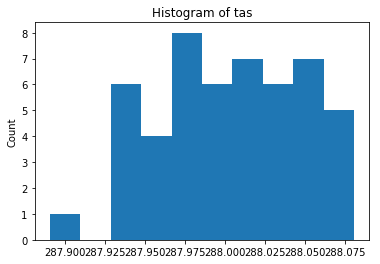

In [204]:
gmensDS['all']['tas']['tas'].plot.hist()




### Figure as above, but include spread in GMT from ensembles

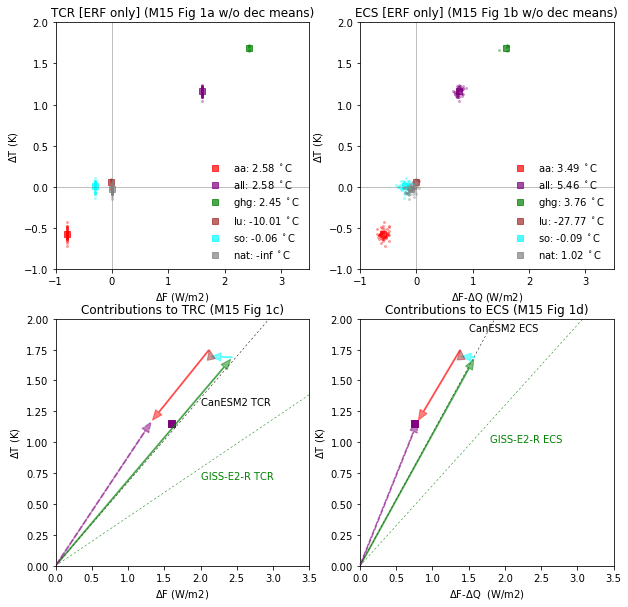

In [127]:
printtofile=False

ms=6
sms=4
fig,axs = plt.subplots(2,2,figsize=(10,10))
ax=axs[0,0]
field='tas'
#ensRFs = np.ones(50)
#print ensRFs*RFdt['all']
#print gmensDS['all'][field][field].values

for rfk in gmanomDT.keys():
    ax.plot(RFdt[rfk], gmanomDT[rfk][field],marker='s',markersize=ms,
           color=colordt[rfk],linestyle='none',alpha=.7)
for rfk in gmanomDT.keys():
    ensRFs = np.ones(len(gmensDS[rfk][field][field].values))
    ax.plot(ensRFs*RFdt[rfk],gmensDS[rfk][field][field].values-ctlgmds[field][field].values,
            marker='.',markersize=sms,alpha=0.3,color=colordt[rfk],linestyle='none')
ax.axhline(y=0,color='0.5',linewidth=0.5)
ax.axvline(x=0,color='0.5',linewidth=0.5)

ret = ax.legend(legstrstcr,frameon=False,loc='lower right')



ax.set_xlabel('$\Delta$F (W/m2)')
ax.set_xlim((-1,3.5))
ax.set_ylim((-1,2))
ax.set_ylabel('$\Delta$T (K)')
ax.set_title('TCR [ERF only] (M15 Fig 1a w/o dec means)')

ax=axs[0,1]
for rfk in gmanomDT.keys():
    ax.plot(RFdt[rfk]-gmanomDT[rfk]['nettoa'], gmanomDT[rfk][field],
            marker='s',markersize=ms,color=colordt[rfk],linestyle='none',alpha=.7)
for rfk in gmanomDT.keys():
    tanom = gmensDS[rfk][field][field].values-ctlgmds[field][field].values
    toaanom = gmensDS[rfk]['nettoa']['nettoa'].values-ctlgmds['nettoa']['nettoa'].values
    ax.plot(RFdt[rfk]-toaanom,tanom,
            marker='.',markersize=sms,alpha=0.3,color=colordt[rfk],linestyle='none')
    
ax.axhline(y=0,color='0.5',linewidth=0.5)
ax.axvline(x=0,color='0.5',linewidth=0.5)
ret = ax.legend(legstrsecs,frameon=False,loc='lower right')
ax.set_xlabel('$\Delta$F-$\Delta$Q (W/m2)')
ax.set_xlim((-1,3.5))
ax.set_ylim((-1,2))
ax.set_ylabel('$\Delta$T (K)')
ax.set_title('ECS [ERF only] (M15 Fig 1b w/o dec means)')

headl=10
headw=8
ax=axs[1,0]
ax.plot(RFdt['all'], gmanomDT['all'][field],marker='s',markersize=7,
        color=colordt['all'])
# xy is head loc, xytext is tail loc  
ax.annotate('',xy=(RFdt['ghg'], gmanomDT['ghg'][field]), 
            xytext=(0,0),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['ghg'],
                            edgecolor=colordt['ghg'],shrink=.01,alpha=0.5)) 
xtail=RFdt['ghg']
ytail=gmanomDT['ghg'][field]
xhead = RFdt['so']+RFdt['ghg']
yhead = gmanomDT['so'][field]+gmanomDT['ghg'][field]
ax.annotate('',xy=(xhead,yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['so'],
                            edgecolor=colordt['so'],shrink=.01,alpha=0.5)) 
xtail=xhead
ytail=yhead
xhead=xtail+RFdt['lu']
yhead=ytail+gmanomDT['lu'][field]
ax.annotate('',xy=(xhead, yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['lu'],
                            edgecolor=colordt['lu'],shrink=.01,alpha=0.5)) 
xtail=xhead
ytail=yhead
xhead=xtail+RFdt['aa']
yhead=ytail+gmanomDT['aa'][field]
ax.annotate('',xy=(xhead,yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['aa'],
                            edgecolor=colordt['aa'],shrink=.01,alpha=0.5)) 
xtail=0
ytail=0
# same head as before, which is vector sum
ax.annotate('',xy=(xhead,yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['all'],
                            edgecolor=colordt['all'],shrink=.01,alpha=0.5,
                            linestyle='dashed')) 
# CanESM2 TCR vals from Forster et al. 2013 GRL
lamtcr = 1.4/Fco2 # 1.4 is GISS TCR (Marvel et al. 2015). slope is inverse of lambda 
xx=np.arange(0,5)
yy = lamtcr * xx
ax.plot(xx,yy,color='g',linestyle='dotted',linewidth=0.5)
ax.annotate('GISS-E2-R TCR',xy=(2,.7),color='g')
lamtcr = 2.4/Fco2 # 2.4 is CanESM2 TCR (Forster et al. 2013 GRL)
yy = lamtcr * xx
ax.plot(xx,yy,color='k',linestyle='dotted',linewidth=0.5)
ax.annotate('CanESM2 TCR',xy=(2,1.3),color='k')
ax.set_xlabel('$\Delta$F (W/m2)')
ax.set_xlim((0,3.5))
ax.set_ylim((0,2))
ax.set_ylabel('$\Delta$T (K)')
ax.set_title('Contributions to TRC (M15 Fig 1c)')


headl=10
headw=8
ax=axs[1,1]
field='tas'
ax.plot(RFdt['all']-gmanomDT['all']['nettoa'], gmanomDT['all'][field],
        marker='s',markersize=7,
        color=colordt['all'])
# xy is head loc, xytext is tail loc  
ax.annotate('',xy=(RFdt['ghg']-gmanomDT['ghg']['nettoa'], gmanomDT['ghg'][field]), 
            xytext=(0,0),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['ghg'],
                            edgecolor=colordt['ghg'],shrink=.01,alpha=0.5)) 
xtail=RFdt['ghg']-gmanomDT['ghg']['nettoa']
ytail=gmanomDT['ghg'][field]
xhead = (RFdt['so']-gmanomDT['so']['nettoa'])+(RFdt['ghg']-gmanomDT['ghg']['nettoa'])
yhead = gmanomDT['so'][field]+gmanomDT['ghg'][field]
ax.annotate('',xy=(xhead,yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['so'],
                            edgecolor=colordt['so'],shrink=.01,alpha=0.5)) 
xtail=xhead
ytail=yhead
xhead=xtail+(RFdt['lu']-gmanomDT['lu']['nettoa'])
yhead=ytail+gmanomDT['lu'][field]
ax.annotate('',xy=(xhead, yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['lu'],
                            edgecolor=colordt['lu'],shrink=.01,alpha=0.5)) 
xtail=xhead
ytail=yhead
xhead=xtail+(RFdt['aa']-gmanomDT['aa']['nettoa'])
yhead=ytail+gmanomDT['aa'][field]
ax.annotate('',xy=(xhead,yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['aa'],
                            edgecolor=colordt['aa'],shrink=.01,alpha=0.5)) 
xtail=0
ytail=0
# same head as before, which is vector sum
ax.annotate('',xy=(xhead,yhead), 
            xytext=(xtail,ytail),
            arrowprops=dict(width=1,headlength=headl,headwidth=headw,
                            facecolor=colordt['all'],
                            edgecolor=colordt['all'],shrink=.01,alpha=0.5,
                            linestyle='dashed')) 
slopeecs = 2.3/Fco2 # 2.3 is GISS ECS. slope is inverse of lambda 
xx=np.arange(0,5)
yy = slopeecs * xx
ax.plot(xx,yy,color='g',linestyle='dotted',linewidth=0.5)
ax.annotate('GISS-E2-R ECS',xy=(1.8,1),color='g')
slopeecs = 3.8/Fco2 # 3.69 is CanESM2 ECS. slope is inverse of lambda 
yy = slopeecs * xx
ax.plot(xx,yy,color='k',linestyle='dotted',linewidth=0.5)
ax.annotate('CanESM2 ECS',xy=(1.5,1.9))
# Add CanESM2's ECS: 3.69C Andrews et al. 2012 GRL
ax.set_xlabel('$\Delta$F-$\Delta$Q  (W/m2)')
ax.set_xlim((0,3.5))
ax.set_ylim((0,2))
ax.set_ylabel('$\Delta$T (K)')
ax.set_title('Contributions to ECS (M15 Fig 1d)')

if printtofile:    
    fig.savefig('CanESM2_TCR_ECS_singleforcing_withspread.pdf')

It looks like for ECS, solar & volcanic are not important, because the sum of the single forcings already equals the historical mean without them. This makes sense to me since they are more transient forcings that either disappear or are tiny in the case of volcanoes, or average out because it's cyclic in the case of solar. Of course, the match could also be coincidental given we are missing tropo ozone as well, and the RFs may be slightly inconsistent with the piControl control period.

### plot dQ v dT and investigate


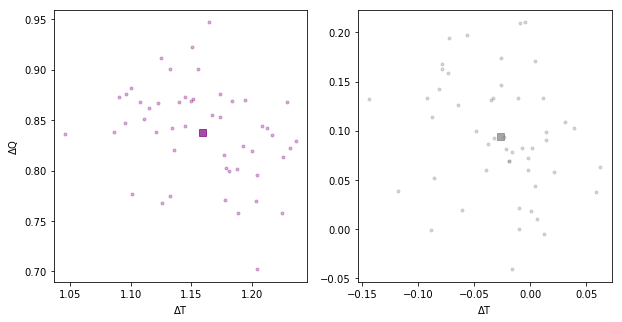

In [23]:

rfk = 'all'

fig,axs = plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
ax.plot(gmanomDT[rfk][field], gmanomDT[rfk]['nettoa'],
        marker='s',markersize=ms+1,color=colordt[rfk],linestyle='none',alpha=.7)

tanom = gmensDS[rfk][field][field].values-ctlgmds[field][field].values
toaanom = gmensDS[rfk]['nettoa']['nettoa'].values-ctlgmds['nettoa']['nettoa'].values
ax.plot(tanom,toaanom,marker='.',
        markersize=sms+2,alpha=0.3,color=colordt[rfk],linestyle='none')
ax.set_xlabel('$\Delta$T')
ax.set_ylabel('$\Delta$Q')

rfk = 'nat'
ax=axs[1]
ax.plot(gmanomDT[rfk][field], gmanomDT[rfk]['nettoa'],
        marker='s',markersize=ms+1,color=colordt[rfk],linestyle='none',alpha=.7)

tanom = gmensDS[rfk][field][field].values-ctlgmds[field][field].values
toaanom = gmensDS[rfk]['nettoa']['nettoa'].values-ctlgmds['nettoa']['nettoa'].values
ax.plot(tanom,toaanom,marker='.',
        markersize=sms+2,alpha=0.3,color=colordt[rfk],linestyle='none')
ax.set_xlabel('$\Delta$T')


### Reread 2D data but keep whole time dim

In [4]:
casetsDS={}

# 2D vars
for ensname in ('all','nat','aa','so','ghg','lu'):# si:
    casename=ensnamesDT[ensname]
    pnum=pnumDT[ensname]
    timeext = timeextDT[ensname]
    basepath,subd = dirsDT[ensname]
    fldDS={}

    for field in ('tas','nettoa'):
            
        comp = compDT[field]
        fn = basepath+'/'+casename+subd+'/'+field+'/'+field+'_'+comp+'_CanESM2_'+casename+\
             subd+'_r*i1p'+pnum+'_'+timeext+'.nc'
        print fn
        # this creates a new dimension to concatenate on
        fldDS[field] = xr.open_mfdataset(fn,concat_dim='ensemble',
                                         autoclose=True)
        #print fldDS[field]

    casetsDS[ensname] = fldDS


/Users/kelly/DATA/CanSISE/CanESM2/LE//historical-r?/tas/tas_Amon_CanESM2_historical-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historical-r?/nettoa/nettoa_Amon_CanESM2_historical-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historicalNat-r?/tas/tas_Amon_CanESM2_historicalNat-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historicalNat-r?/nettoa/nettoa_Amon_CanESM2_historicalNat-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historicalMisc-r?/tas/tas_Amon_CanESM2_historicalMisc-r?_r*i1p4_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historicalMisc-r?/nettoa/nettoa_Amon_CanESM2_historicalMisc-r?_r*i1p4_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historicalMisc-r?/tas/tas_Amon_CanESM2_historicalMisc-r?_r*i1p6_195001-200012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historicalMisc-r?/nettoa/nettoa_Amon_CanESM2_historicalMisc-r?_r*i1p6_195001-200012.nc
/Users/kelly/DATA/CanSISE/CanESM2//historica

In [5]:
# starting with casetsDS, compute ann, global average, but keep ensemble and time dim

gmanntsDT={}
for ens in ('all','nat','aa','so','ghg','lu'): #, 'si'):
    fldDT={}
    for field in ('tas','nettoa'):
        fldDT[field] = dsu.calc_annual_mean_ds(dsu.calc_areaweight_mean_ds(casetsDS[ens][field],
                                                                             dim=('lat','lon')))
    gmanntsDT[ens] = fldDT
        
#allts = casetsDS['all']['tas']
#alltsgm = dsu.calc_areaweight_mean_ds(allts,dim=('lat','lon'))
#alltsgmann = dsu.calc_annual_mean_ds(alltsgm)

#print alltsgmann

#alltoa = casetsDS['all']['nettoa']
#alltoagm = dsu.calc_areaweight_mean_ds(alltoa,dim=('lat','lon'))
#alltoagmann = dsu.calc_annual_mean_ds(alltoagm)

#print alltoagmann


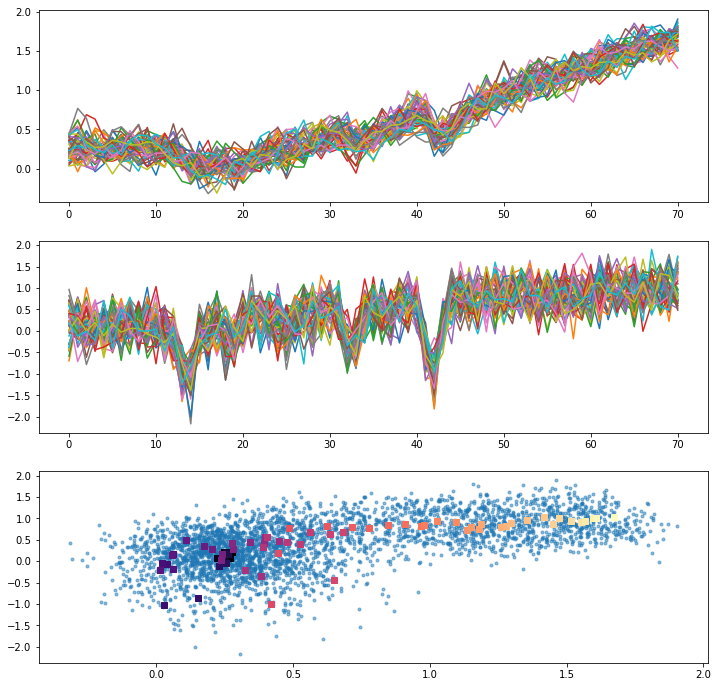

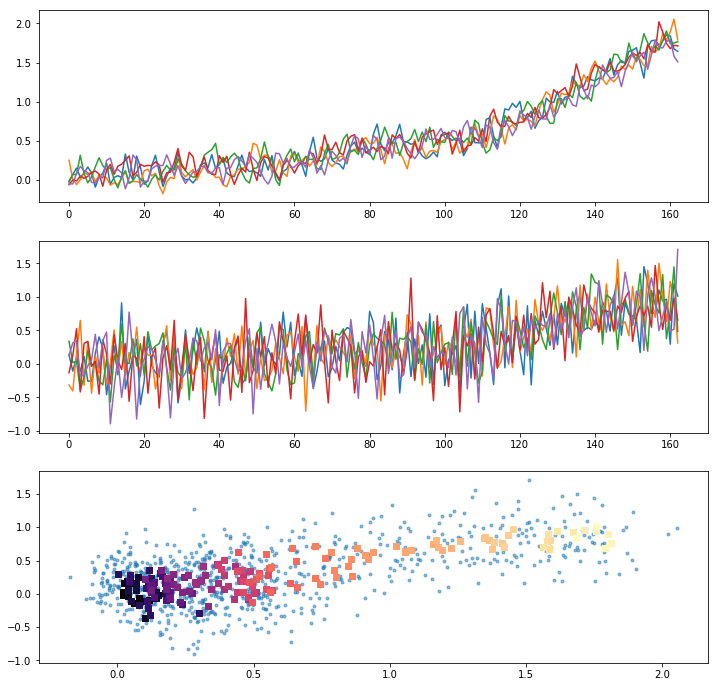

In [12]:
ens='all'
xx=np.arange(gmanntsDT[ens]['tas'].year.shape[0])

fig,axs=plt.subplots(3,1,figsize=(12,12))
ax=axs[0]
ret = ax.plot(gmanntsDT[ens]['tas']['tas']-ctlgmds['tas']['tas'])
ax=axs[1]
ret = ax.plot(gmanntsDT[ens]['nettoa']['nettoa']-ctlgmds['nettoa']['nettoa'])
ax=axs[2]
ret = ax.scatter(gmanntsDT[ens]['tas']['tas']-ctlgmds['tas']['tas'],
                 gmanntsDT[ens]['nettoa']['nettoa']-ctlgmds['nettoa']['nettoa'],
                 marker='.',alpha=.5)#,c=xx,cmap='magma')
#cplt.add_regressline(alltsgmann['tas'],alltoagmann['nettoa'], ax=ax)
ret = ax.scatter(gmanntsDT[ens]['tas']['tas'].mean(dim='ensemble')-ctlgmds['tas']['tas'],
                 gmanntsDT[ens]['nettoa']['nettoa'].mean(dim='ensemble')-ctlgmds['nettoa']['nettoa'],
                 marker='s',c=xx,cmap='magma')


ens='ghg'
xx=np.arange(gmanntsDT[ens]['tas'].year.shape[0])

fig,axs=plt.subplots(3,1,figsize=(12,12))
ax=axs[0]
ret = ax.plot(gmanntsDT[ens]['tas']['tas']-ctlgmds['tas']['tas'])
ax=axs[1]
ret = ax.plot(gmanntsDT[ens]['nettoa']['nettoa']-ctlgmds['nettoa']['nettoa'])
ax=axs[2]
ret = ax.scatter(gmanntsDT[ens]['tas']['tas']-ctlgmds['tas']['tas'],
                 gmanntsDT[ens]['nettoa']['nettoa']-ctlgmds['nettoa']['nettoa'],
                 marker='.',alpha=.5)#,c=xx,cmap='magma')
#cplt.add_regressline(alltsgmann['tas'],alltoagmann['nettoa'], ax=ax)
ret = ax.scatter(gmanntsDT[ens]['tas']['tas'].mean(dim='ensemble')-ctlgmds['tas']['tas'],
                 gmanntsDT[ens]['nettoa']['nettoa'].mean(dim='ensemble')-ctlgmds['nettoa']['nettoa'],
                 marker='s',c=xx,cmap='magma')


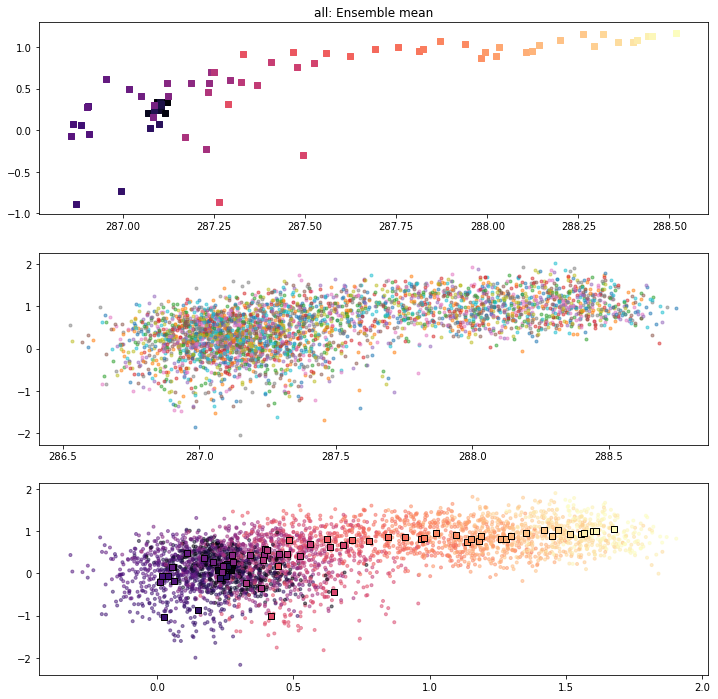

In [97]:
ens='all'
xx=np.arange(gmanntsDT[ens]['tas'].year.shape[0])

fig,axs=plt.subplots(3,1,figsize=(12,12))
ax=axs[0]
ax.scatter(gmanntsDT[ens]['tas']['tas'].data.mean(axis=1),
           gmanntsDT[ens]['nettoa']['nettoa'].data.mean(axis=1),               
           marker='s',c=xx,cmap='magma')
ax.set_title(ens + ': Ensemble mean')
ax=axs[1]
for enmem in gmanntsDT[ens]['tas']['tas'].ensemble:
    ax.scatter(gmanntsDT[ens]['tas']['tas'].data[:,enmem.data],
               gmanntsDT[ens]['nettoa']['nettoa'].data[:,enmem.data],               
               marker='.',alpha=.5)
ax=axs[2]
for enmem in gmanntsDT[ens]['tas']['tas'].ensemble:
    ax.scatter(gmanntsDT[ens]['tas']['tas'].data[:,enmem.data]-ctlgmds['tas']['tas'],
               gmanntsDT[ens]['nettoa']['nettoa'].data[:,enmem.data]-ctlgmds['nettoa']['nettoa'],               
               marker='.',alpha=.5,
               c=xx,cmap='magma')
ax.scatter(gmanntsDT[ens]['tas']['tas'].data.mean(axis=1)-ctlgmds['tas']['tas'],
           gmanntsDT[ens]['nettoa']['nettoa'].data.mean(axis=1)-ctlgmds['nettoa']['nettoa'],               
           marker='s',c=xx,cmap='magma',edgecolor='k')
    

#cplt.add_regressline(alltsgmann['tas'],alltoagmann['nettoa'], ax=ax)
    

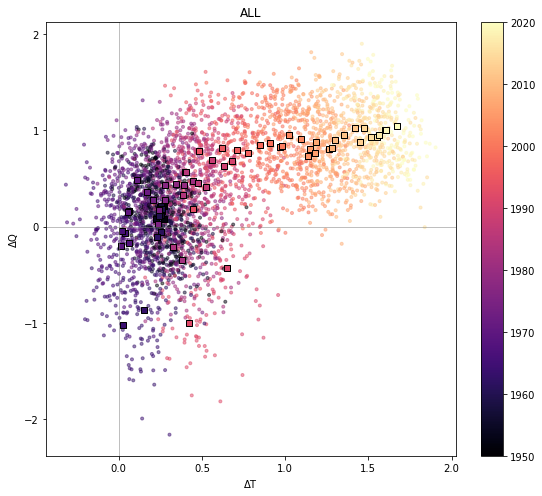

In [13]:
printtofile=False

ens='all'
xx= gmanntsDT[ens]['tas'].year

fig,ax=plt.subplots(1,1,figsize=(8,7))

for enmem in gmanntsDT[ens]['tas']['tas'].ensemble:
    ax.scatter(gmanntsDT[ens]['tas']['tas'].data[:,enmem.data]-ctlgmds['tas']['tas'],
               gmanntsDT[ens]['nettoa']['nettoa'].data[:,enmem.data]-ctlgmds['nettoa']['nettoa'],               
               marker='.',alpha=.5,
               c=xx,cmap='magma')
sc = ax.scatter(gmanntsDT[ens]['tas']['tas'].data.mean(axis=1)-ctlgmds['tas']['tas'],
           gmanntsDT[ens]['nettoa']['nettoa'].data.mean(axis=1)-ctlgmds['nettoa']['nettoa'],               
           marker='s',c=xx,cmap='magma',edgecolor='k')
ax.set_ylabel('$\Delta$Q')
ax.set_xlabel('$\Delta$T')
ax.set_title(str.upper(ens))
ax.axhline(y=0,color='0.5',linewidth=.5)
ax.axvline(x=0,color='0.5',linewidth=.5)

fig.tight_layout()
fig.colorbar(sc,ax=ax,orientation='vertical')

if printtofile:
    fig.savefig('dT_v_dQ_'+ens+'ens_scatterwithtime.pdf')
    


### impose running mean on same plot as above


(71,)


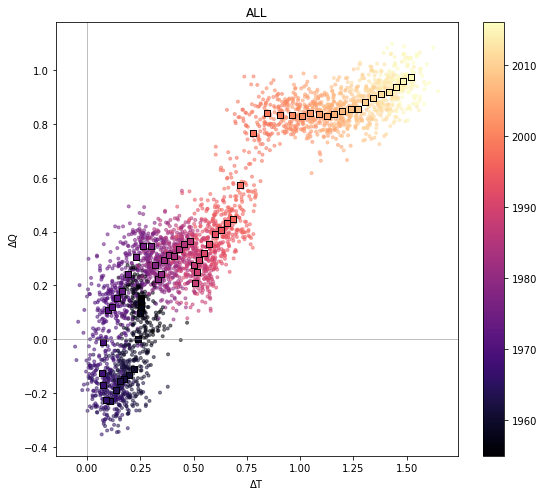

In [33]:
printtofile=False
window=10

# TODO: label important years like volcanic eruptions and big el ninos.
#       Note that the year is actually the decadal mean centered on the listed year. @@
ens='all'
xx= gmanntsDT[ens]['tas'].year
xxrun=np.arange(gmanntsDT[ens]['tas'].year[0]+window/2,
                gmanntsDT[ens]['tas'].year[-1]-window/2+2)

tasmean=cutl.runmean(np.array(gmanntsDT[ens]['tas']['tas'].data.mean(axis=1)-\
                                  ctlgmds['tas']['tas']),window=window,axis=0)
toamean=cutl.runmean(np.array(gmanntsDT[ens]['nettoa']['nettoa'].data.mean(axis=1)-\
                         ctlgmds['nettoa']['nettoa']),window=window)
    
fig,ax=plt.subplots(1,1,figsize=(8,7))

print np.array(gmanntsDT[ens]['tas']['tas'].data[:,enmem.data]-ctlgmds['tas']['tas']).shape

for enmem in gmanntsDT[ens]['tas']['tas'].ensemble:
    # Need to convert dask data to np.array for runmean to work
    tas=cutl.runmean(np.array(gmanntsDT[ens]['tas']['tas'].data[:,enmem.data]-\
                              ctlgmds['tas']['tas']),
                     window=window,axis=0)
    toa=cutl.runmean(np.array(gmanntsDT[ens]['nettoa']['nettoa'].data[:,enmem.data]-\
                     ctlgmds['nettoa']['nettoa']),window=window)
    ax.scatter(tas,toa,marker='.',alpha=.5,
               c=xxrun,cmap='magma')
    # mean of individual runmeans? Or, runmean the ensemble mean? think it might be the same.
    #    runmean the ensemble mean (move that step out of loop):   
    sc = ax.scatter(tasmean,toamean,               
                   marker='s',c=xxrun,cmap='magma',edgecolor='k')
    #sc = ax.scatter(gmanntsDT[ens]['tas']['tas'].data.mean(axis=1)-ctlgmds['tas']['tas'],
    #           gmanntsDT[ens]['nettoa']['nettoa'].data.mean(axis=1)-ctlgmds['nettoa']['nettoa'],               
    #           marker='s',c=xx,cmap='magma',edgecolor='k')
ax.set_ylabel('$\Delta$Q')
ax.set_xlabel('$\Delta$T')
ax.set_title(str.upper(ens))
ax.axhline(y=0,color='0.5',linewidth=.5)
ax.axvline(x=0,color='0.5',linewidth=.5)

fig.tight_layout()
fig.colorbar(sc,ax=ax,orientation='vertical')

if printtofile:
    fig.savefig('dT_v_dQ_'+ens+'ens_scatterwithtime_run'+str(window)+'.pdf')
  

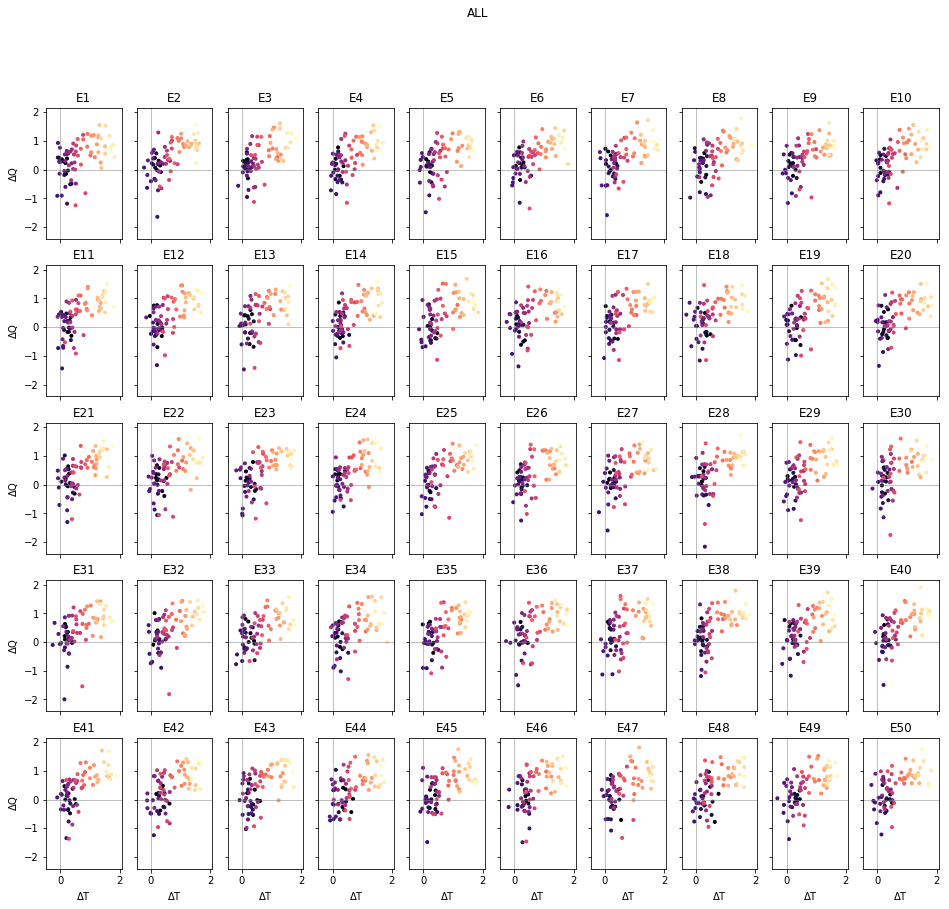

In [125]:
ens='all'
xx= gmanntsDT[ens]['tas'].year

if ens in ('all','nat','aa','so'):
    fig,axs=plt.subplots(5,10,figsize=(16,14),sharex=True,sharey=True)    
else:
    fig,axs=plt.subplots(1,5,figsize=(8,2),sharex=True,sharey=True)
    
aii=0


for ax in axs.reshape(-1):
    ax.scatter(gmanntsDT[ens]['tas']['tas'].data[:,aii]-ctlgmds['tas']['tas'],
           gmanntsDT[ens]['nettoa']['nettoa'].data[:,aii]-ctlgmds['nettoa']['nettoa'],               
           marker='.',c=xx,cmap='magma')
    #ax.set_ylim((-2.2,2.2)) # absolute
    #ax.set_xlim((286,289.5)) # absolute
    #ax.set_ylim((-2.2,2.2)) # anomaly
    #ax.set_xlim((-0.5,2))  # anomaly
    if not ax.is_last_row():
        #ax.set_xticklabels('')
        pass
    else:
        ax.set_xlabel('$\Delta$T')
    if not ax.is_first_col():
        #ax.set_yticklabels('')
        pass
    else:
        ax.set_ylabel('$\Delta$Q')
        
    ax.set_title('E'+str(aii+1))
    ax.axhline(y=0,color='0.5',linewidth=.5)
    ax.axvline(x=0,color='0.5',linewidth=.5)
    aii+=1

fig.suptitle(str.upper(ens))

if printtofile:
    fig.savefig('dT_v_dQ_'+ens+'ensmems_scatterwithtime_subplot.pdf',
               bbox_inches='tight')
    


In [ ]:


print ctlgmds

